In [1]:
#For Calculations
import math
import numpy as np
import numpy.linalg as la
import numpy.ma as ma
import scipy as scp
from scipy import optimize
from cmath import sqrt
import random
from scipy.linalg import expm
import scipy.integrate as integrate
from scipy import signal
from scipy.special import erf

from numpy.random import default_rng
rng = default_rng()


#For parallel computing
from joblib import Parallel, delayed
import Encoding_Certainty_Functions as fun

In [2]:
#For Plotting results and Figures
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as tick

#Progress Bars
from tqdm.notebook import tqdm

#Setting Defaults For Plotting
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title
#Setting Linewidths
plt.rc('lines', linewidth=5.0)
#Graphic resolution
plt.rcParams['figure.dpi'] = 200

# Stationary Solutions and Stability

Here we will define the synaptic weight kernels, demonstrate how one may choose threshold values, and show some figure examples.

In [3]:
#Defining spatial discretization
n=2**12+1
dx=2*np.pi/n
x=np.linspace(-np.pi,np.pi,n)[:-1]

#For ease of interpretation x-axes are plotted in degrees
#Calculations use the radian form of x above
x_deg=np.copy(x)*180/np.pi

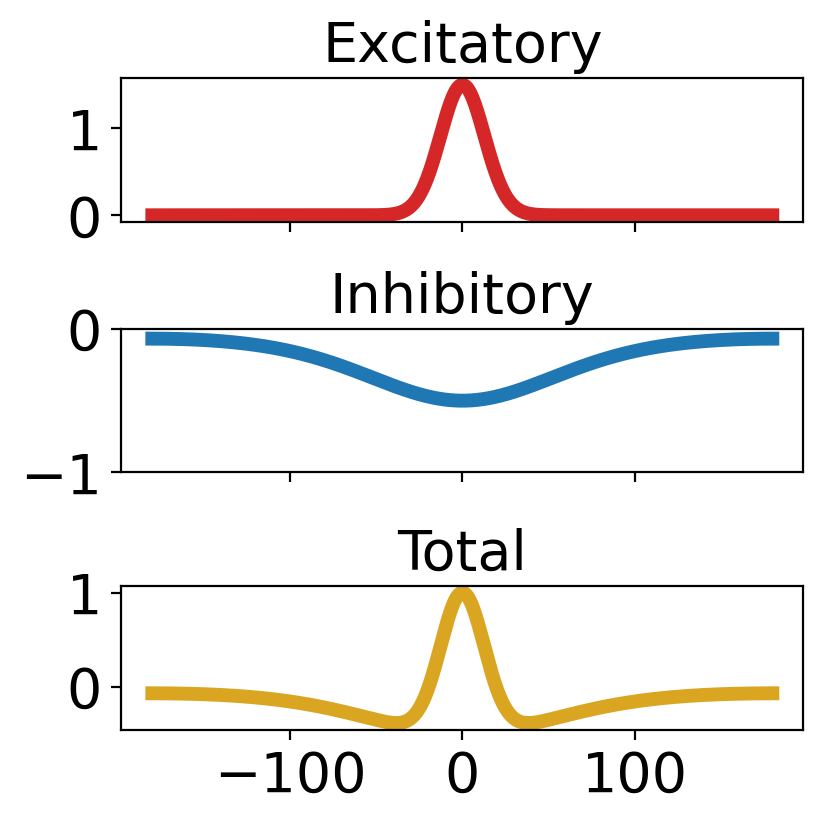

In [4]:
#Choosing weight kernels
weights_e=fun.weight_ker(1.5, 20, 20, x)
weights_i=fun.weight_ker(0.5, 1, 20, x)
weight_tot=weights_e-weights_i

#Obtaining weight kernel coefficients needed for subsequent calculations
w_coeffs=fun.weight_coeff(1.5, 20, 20)-fun.weight_coeff(0.5, 1, 20)

#Plotting weight kernels
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(4, 4), sharex=True, constrained_layout = True)
ax1.plot(x_deg,weights_e, color='tab:red')
ax1.set_title('Excitatory')

ax2.plot(x_deg,-weights_i, color='tab:blue')
ax2.set_ylim(-1,0)
ax2.set_title('Inhibitory')

ax3.plot(x_deg,weight_tot, color='goldenrod')
ax3.set_title('Total')
plt.show()

In [5]:
#We set the thresholds
step_theta=[0.035, 0.1, 0.165, 0.234, 0.298]


In [6]:
Tend=100
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0,
    'tcs': 0,
    'tce': 0.5,
    'Tend': Tend,
}
Result0=fun.simulation(x, weight_tot, Input, step_theta,**FixedParams)

FixedParams['tce']=3
Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=5
Result2=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=7
Result3=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=9
Result4=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

FixedParams['tce']=11
Result5=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

#normalized coefficients from simulation
Theory,UC=fun.coeff_ansatz_theory(x, w_coeffs, Input, step_theta,**FixedParams)
Normal_Ucoeffs=UC/Theory[-1]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
# Pulling all amplitudes
Amplitudes0=np.max(Result0,axis=0)
Amplitudes1=np.max(Result1,axis=0)
Amplitudes2=np.max(Result2,axis=0)
Amplitudes3=np.max(Result3,axis=0)
Amplitudes4=np.max(Result4,axis=0)
Amplitudes5=np.max(Result5,axis=0)

Text(0.5, 1.0, 'Simulations')

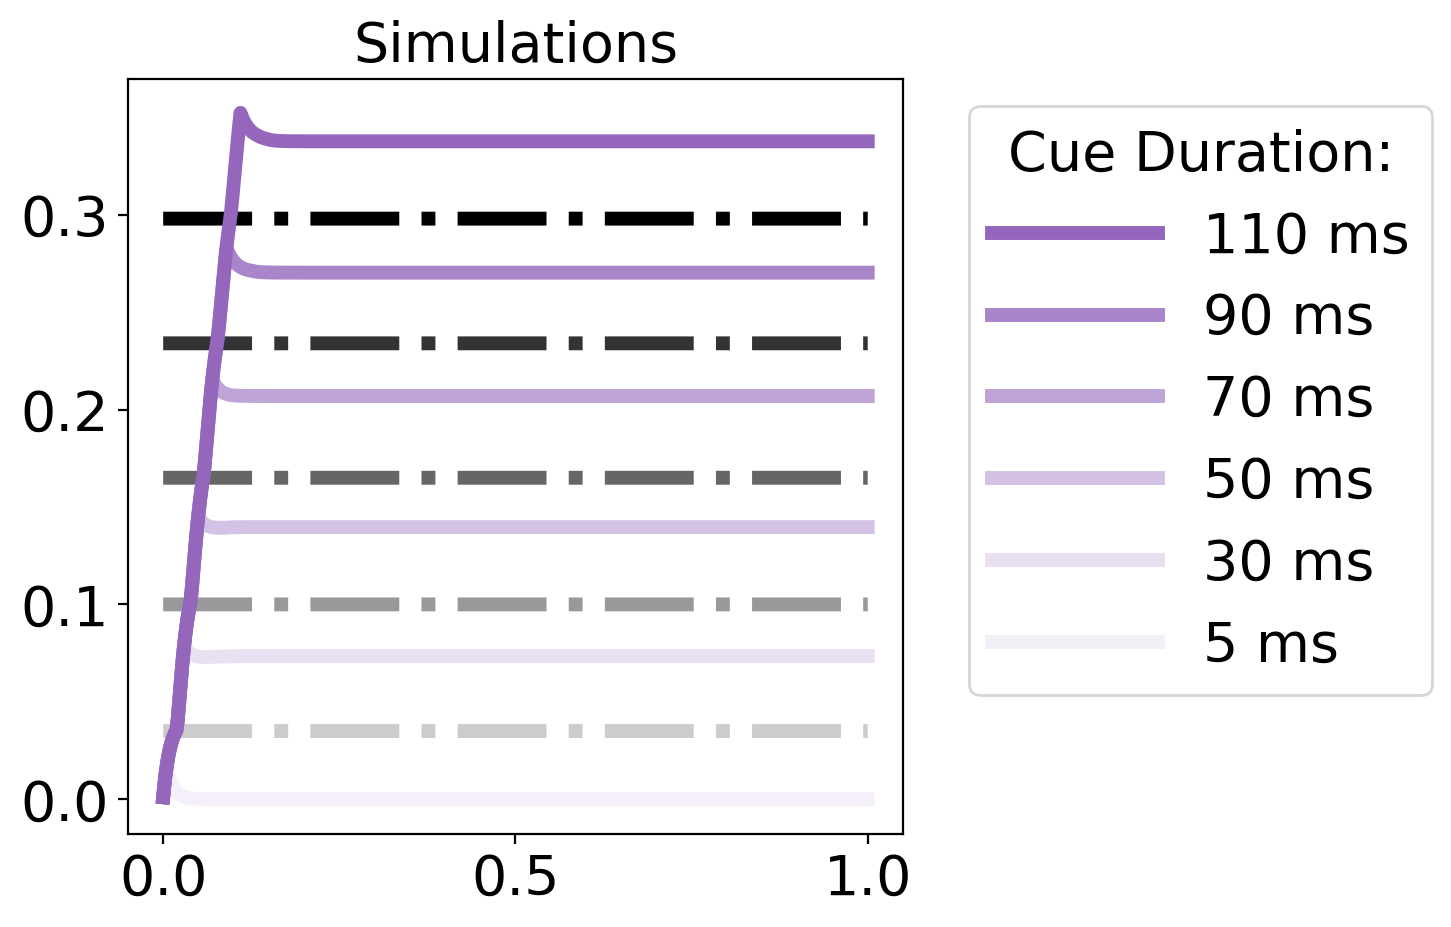

In [8]:
nt=int(Tend/0.025)
timey=np.linspace(0,Tend,nt)/100

fig = plt.figure(figsize=(5, 5))
for i in range(len(step_theta)):
    plt.plot(timey,step_theta[i]*np.ones(nt),'-.', alpha=(i+1)*1/5, color='black')

plt.plot(timey,Amplitudes0, alpha=0.1, color='tab:purple', label='5 ms')
plt.plot(timey,Amplitudes1, alpha=0.2, color='tab:purple', label='30 ms')
plt.plot(timey,Amplitudes2, alpha=0.4, color='tab:purple', label='50 ms')
plt.plot(timey,Amplitudes3, alpha=0.6, color='tab:purple', label='70 ms')
plt.plot(timey,Amplitudes4, alpha=0.8, color='tab:purple', label='90 ms')
plt.plot(timey,Amplitudes5, alpha=1, color='tab:purple', label='110 ms')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),
           title='Cue Duration:', bbox_to_anchor=(1.05, 1.0),loc='upper left',handlelength=3)
plt.title('Simulations')


### Set U_tilde

max absolute error: 2.3869795029440866e-15


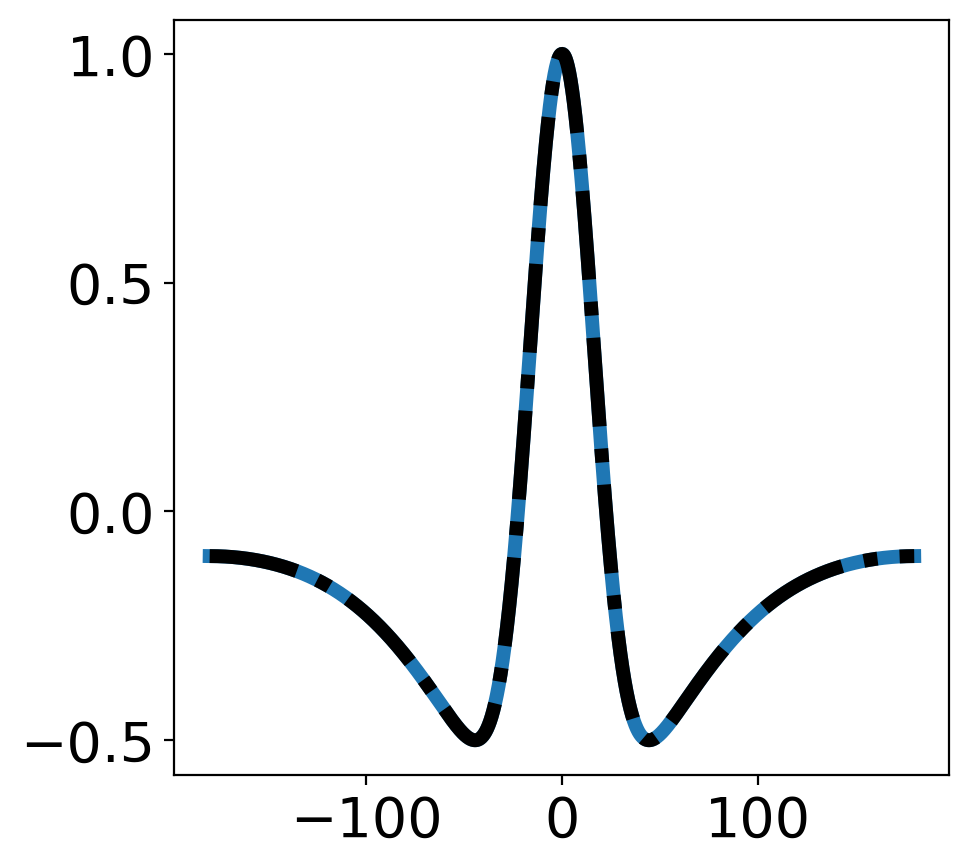

In [10]:
# Set U_tilde either with coefficients or from the final simulation profile
# which have a max absolute error of order 10**(-15)
U_tilde_coeff=np.array(sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))]))
U_tilde_prof=Result5[:,-1]/Amplitudes5[-1]

fig = plt.figure(figsize=(5, 5))
plt.plot(x_deg, U_tilde_coeff)
plt.plot(x_deg, U_tilde_prof,'-.',color='k')

print('max absolute error: '+str(np.max(np.abs(U_tilde_coeff-U_tilde_prof))))

[0.04210489 0.07126742 0.10645149 0.13871599 0.17056034 0.2062371
 0.2412802  0.26950329 0.30453165 0.33599769]


(0.0, 0.4)

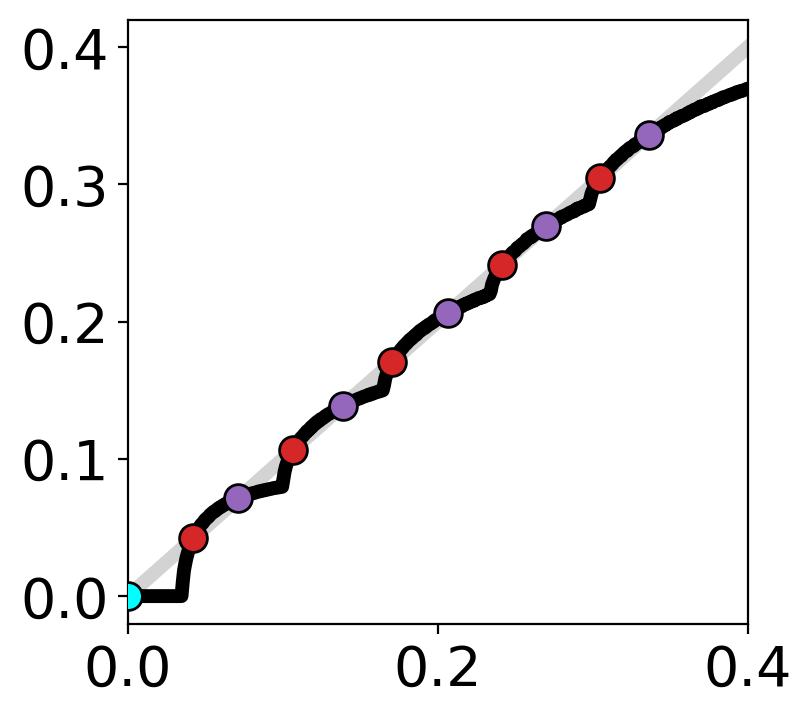

In [11]:
Utilde=U_tilde_coeff
Avec=np.linspace(0.0001,0.4,500)
cc=np.array([np.trapz(Utilde*fun.circular_conv(weight_tot,np.roll(fun.firing(A*Utilde, step_theta),-int((len(x))/2)))*dx,x) for A in Avec])
factor=np.trapz(Utilde**2,x)
ga_nonlinear=np.copy(cc/factor)
amp_sol=fun.find_interfaces(Avec,cc/factor-Avec,0)
print(amp_sol)


fig = plt.figure(figsize=(4, 4))
plt.plot(Avec,Avec,color='lightgrey')
plt.plot(Avec,cc/factor,'k')
plt.scatter(amp_sol[1::2],np.zeros(len(amp_sol[1::2]))+amp_sol[1::2],
            color='tab:purple',edgecolors='black',marker='o',zorder=3,s=100,label='broad solutions')
plt.scatter(amp_sol[0::2],np.zeros(len(amp_sol[1::2]))+amp_sol[0::2],
            color='tab:red',edgecolors='black',marker='o',zorder=3,s=100,label='narrow solutions')
plt.scatter(0,0,
            color='cyan',edgecolors='black',marker='o',zorder=3,s=100,label='trivial solution')
plt.xlim(0,0.4)

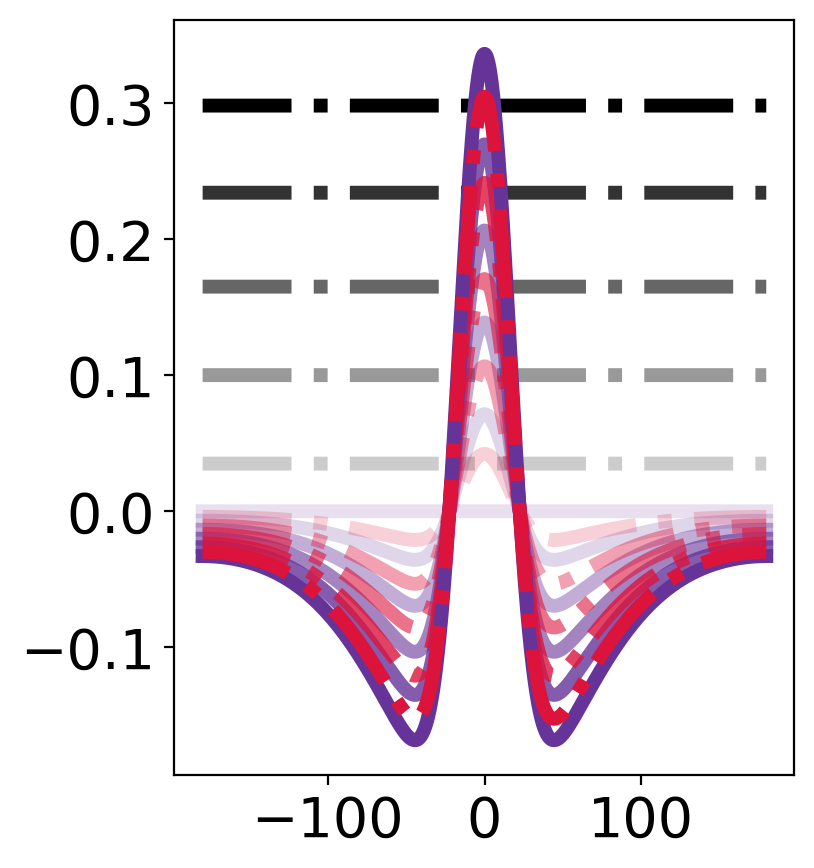

In [12]:
broadsols=amp_sol[1::2]
narrowsols=amp_sol[0::2]

fig = plt.figure(figsize=(4, 5))
for i in range(len(step_theta)):
    plt.plot(x_deg,step_theta[i]*np.ones(len(x)),'-.', alpha=(i+1)/5, color='black')

plt.plot(x_deg,0*Utilde, alpha=0.15, color='rebeccapurple')
for k in range(len(broadsols)):
    plt.plot(x_deg,broadsols[k]*Utilde, alpha=(k+1)/5, color='rebeccapurple')
    plt.plot(x_deg,narrowsols[k]*Utilde, '-.', alpha=(k+1)/5, color='crimson')


# Stochastic Analysis

FOR THE FIVE STEP FIRING RATE

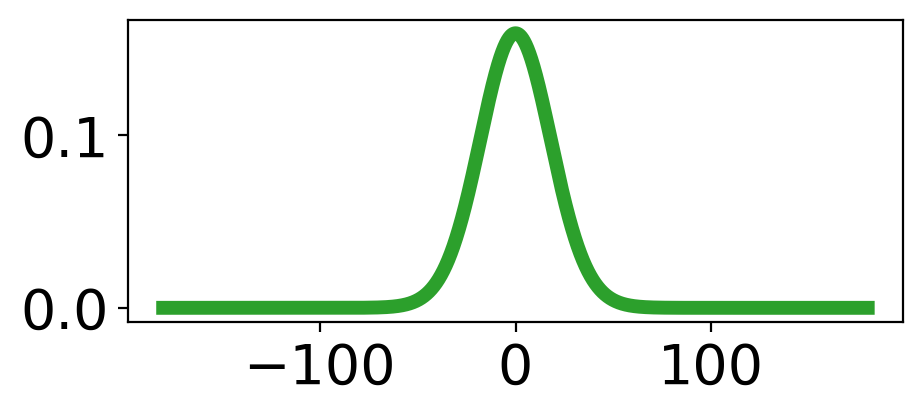

In [13]:
#Noise kernel
noise_ker=fun.weight_ker(1, 10, 20, x)/(2*np.pi)
noise_coeffs=fun.weight_coeff(1, 10, 20)/(2*np.pi)

fig=plt.figure(figsize=(5,2))
plt.plot(x_deg,noise_ker, color='tab:green')

# Special functions for generating plot panels
### Transition noise sample with full model and amplitude ansatz

In [14]:
#For this functions we define the input and epsilon(noise amplitude) vector over time
#to simulate multiple trials
#Defining vectors for epsilon and the input changing in time
Input=1*fun.Tophat(x, -0.02, 0.02)
eps=[0.001]*int(400/0.025)+[0.01]*int(400/0.025)+[0.001]*int(400/0.025)+[0.01]*int(400/0.025)+[0.001]*int(400/0.025)+[0.01]*int(400/0.025)
I0=[Input]*int(20/0.025)+[np.zeros(2)]*int(780/0.025)+[np.roll(Input,200)]*int(20/0.025)+[np.zeros(2)]*int(780/0.025)+[np.roll(Input,-200)]*int(20/0.025)+[np.zeros(2)]*int(780/0.025)
print(len(eps),len(I0))

96000 96000


In [15]:
FixedParams={
    'e': 0.006,
    'tcs': 0,
    'tce': 7,
    'Tend': 2400,
}

cue_duration=np.array([12])
test,amps=fun.simulation_noise_special(x,weight_tot,Utilde,I0,step_theta,noise_ker,eps,0,**FixedParams)


  0%|          | 0/96000 [00:00<?, ?it/s]

In [16]:
index1 = np.argmin(np.abs(x_deg+60))
index2=np.argmin(np.abs(x_deg-60))
nt=int(2400/0.025)
timey0=np.linspace(0,2400,nt)/100

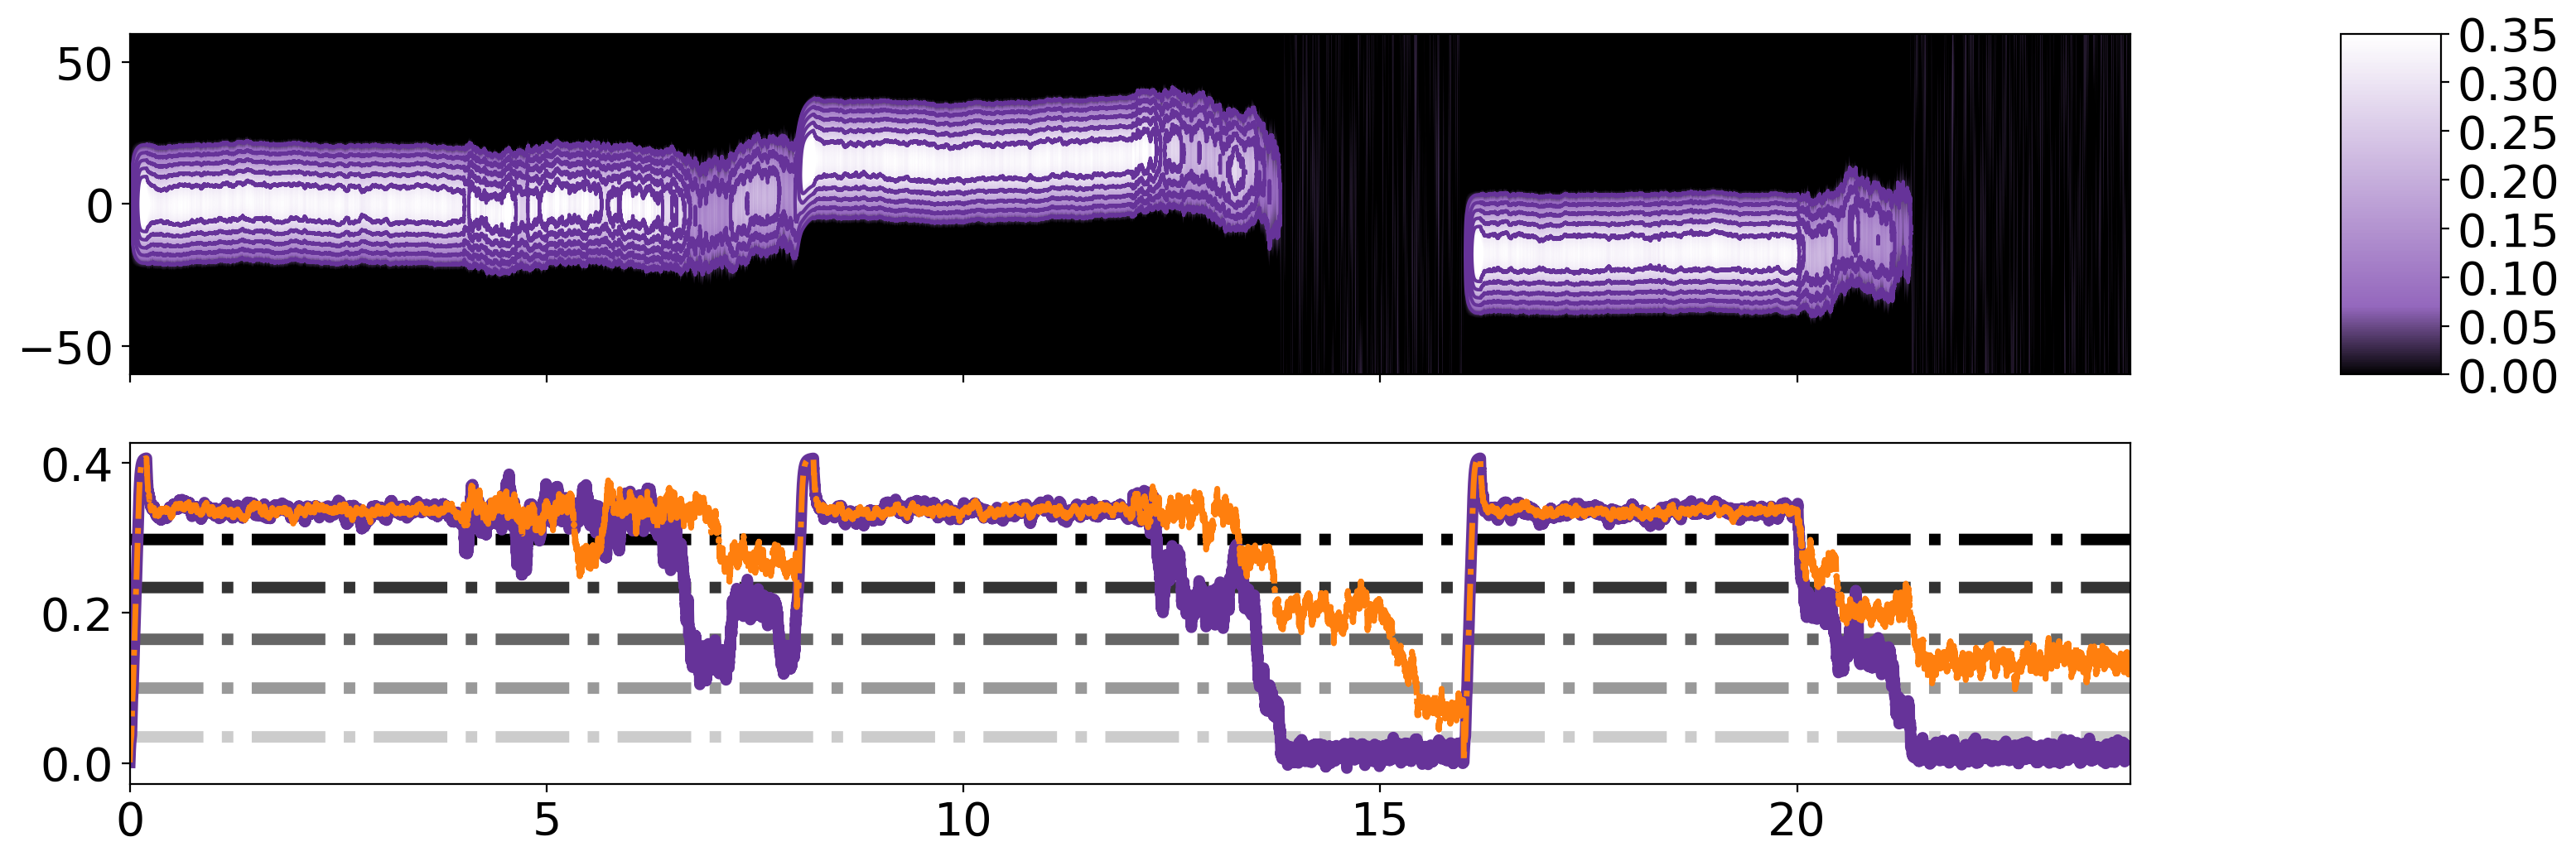

In [17]:
time_shift=int(0/0.025)
Result0=np.roll(test,time_shift)
Amplitudes0=np.max(test,axis=0)

cemap = colors.LinearSegmentedColormap.from_list("", ["black","tab:purple","white"])
divnorme=colors.TwoSlopeNorm(vmin=0, vcenter=0.35/5, vmax=0.35)

skip=2
Y,X = np.meshgrid(x_deg[index1:index2+1], timey0[::skip], indexing='ij')

#Neural Activity
fig, ([ax, cax],[ax2,cax2]) = plt.subplots(ncols=2,nrows=2,figsize=(18,6),
                  gridspec_kw={"width_ratios":[1, 0.05]})
fig.subplots_adjust(wspace=0.2)
im  = ax.pcolormesh(X,Y,Result0[index1:index2+1,::skip],norm=divnorme,
                    cmap=cemap,shading='auto')
ax.contour(X, Y, Result0[index1:index2+1,::skip], levels=step_theta, 
           colors=5*['rebeccapurple'],linewidths=1.5)
fig.colorbar(im, cax=cax)

for i in range(len(step_theta)):
    ax2.plot(timey0[time_shift:],step_theta[i]*np.ones(len(timey0)),'-.', alpha=(i+1)*1/5, color='black')
ax2.plot(timey0[time_shift:],Amplitudes0,color='rebeccapurple')
ax2.plot(timey0[time_shift:],amps,'-.',color='tab:orange',linewidth=2.5)

cax2.axis('off')
ax.get_shared_x_axes().join(ax, ax2)
ax.set_xticklabels([])

plt.show()


### Wandering samples: same noise, different amplitude states

The following demonstrates noise plots for variable amplitude bumps experiencing the same noise. All delay periods are 2 seconds, plots are shifted so that they end at the same time, cues are of different lengths.

In [18]:
Input=1*fun.Tophat(x, -0.02, 0.02)
FixedParams={
    'e': 0.001,
    'tcs': 0,
    'tce': 3,
    'Tend': 200,
}

cue_duration=np.array([3,5,7,9,11])
test=fun.simulation_same_noise(x,weight_tot,Input,step_theta,noise_ker,cue_duration,**FixedParams)


  0%|          | 0/8120 [00:00<?, ?it/s]

  0%|          | 0/8200 [00:00<?, ?it/s]

  0%|          | 0/8280 [00:00<?, ?it/s]

  0%|          | 0/8360 [00:00<?, ?it/s]

  0%|          | 0/8440 [00:00<?, ?it/s]

In [19]:
index1 = np.argmin(np.abs(x_deg+60))
index2=np.argmin(np.abs(x_deg-60))
nt=int(211/0.025)
timey0=np.linspace(0,211,nt)/100


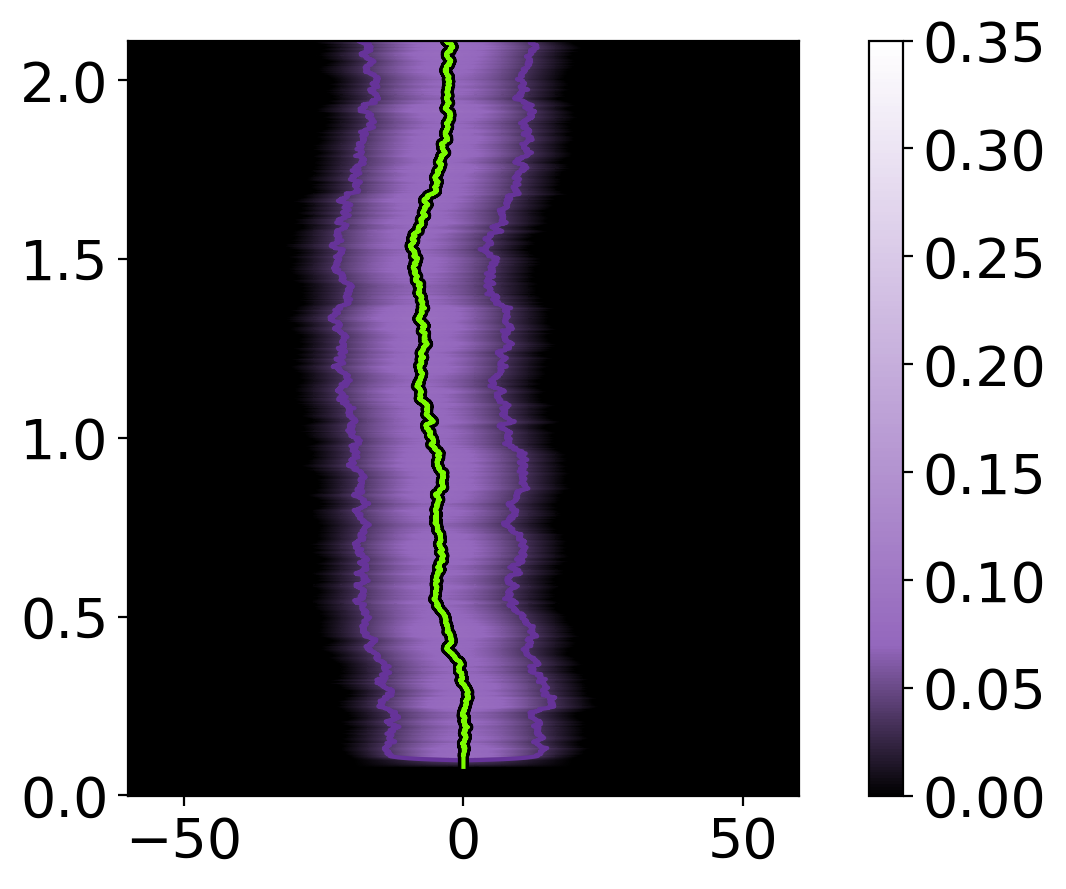

In [20]:
time_shift=int(8/0.025)
Result0=np.roll(test[:,:,0],time_shift)
Amplitudes0=np.max(test[:,:,0],axis=0)

cemap = colors.LinearSegmentedColormap.from_list("", ["black","tab:purple","white"])
divnorme=colors.TwoSlopeNorm(vmin=0, vcenter=0.35/5, vmax=0.35)

skip=2
X, Y = np.meshgrid(x_deg[index1:index2+1], timey0[::skip], indexing='ij')

#Neural Activity
fig, (ax, cax) = plt.subplots(ncols=2,figsize=(5,5), 
                  gridspec_kw={"width_ratios":[1, 0.05]})
fig.subplots_adjust(wspace=0.2)
im  = ax.pcolormesh(X,Y,Result0[index1:index2+1,::skip],norm=divnorme,
                    cmap=cemap,shading='auto')
ax.contour(X, Y, Result0[index1:index2+1,::skip], levels=step_theta, 
           colors=5*['rebeccapurple'],linewidths=1.5)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'k',linewidth=4)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'lawngreen',linewidth=1.5)
fig.colorbar(im, cax=cax)

plt.show()

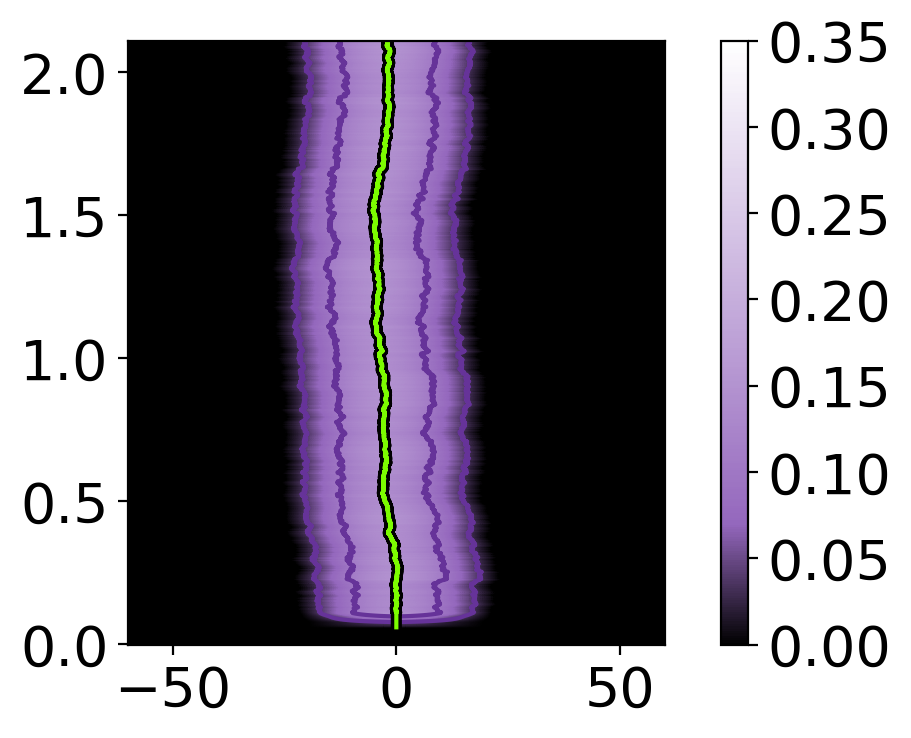

In [21]:
time_shift=int(6/0.025)
Result0=np.roll(test[:,:,1],time_shift)
Amplitudes0=np.max(test[:,:,1],axis=0)

skip=2
X, Y = np.meshgrid(x_deg[index1:index2+1], timey0[::skip], indexing='ij')

#Neural Activity
fig, (ax, cax) = plt.subplots(ncols=2,figsize=(4,4), 
                  gridspec_kw={"width_ratios":[1, 0.05]})
fig.subplots_adjust(wspace=0.2)
im  = ax.pcolormesh(X,Y,Result0[index1:index2+1,::skip],norm=divnorme,
                    cmap=cemap,shading='auto')
ax.contour(X, Y, Result0[index1:index2+1,::skip], levels=step_theta, 
           colors=5*['rebeccapurple'],linewidths=1.5)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'k',linewidth=4)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'lawngreen',linewidth=1.5)
fig.colorbar(im, cax=cax)

plt.show()

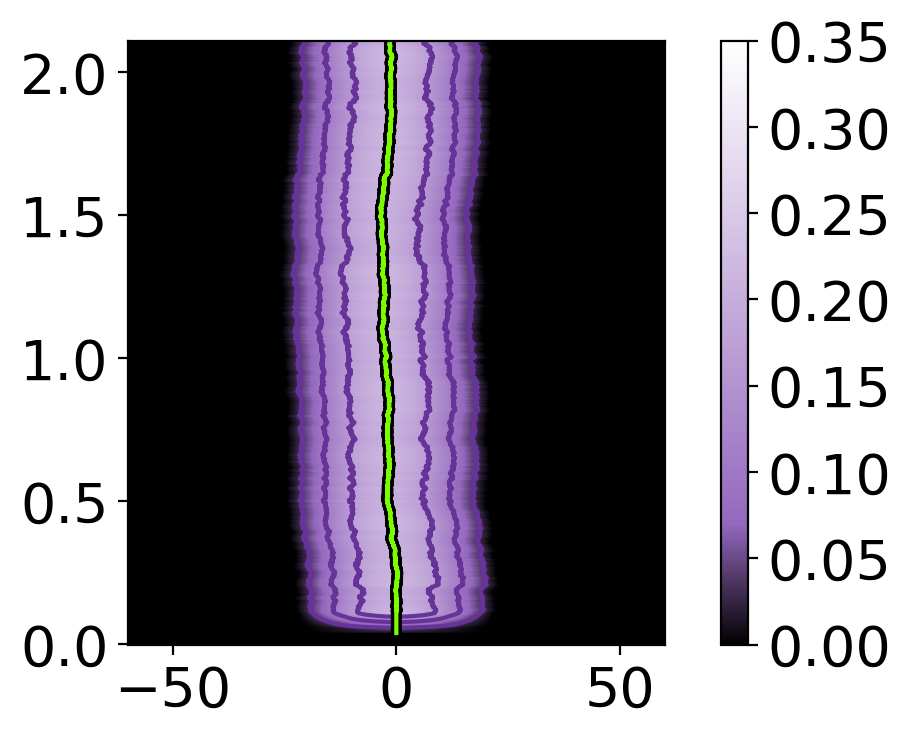

In [22]:
time_shift=int(4/0.025)
Result0=np.roll(test[:,:,2],time_shift)
Amplitudes0=np.max(test[:,:,2],axis=0)

skip=2
X, Y = np.meshgrid(x_deg[index1:index2+1], timey0[::skip], indexing='ij')

#Neural Activity
fig, (ax, cax) = plt.subplots(ncols=2,figsize=(4,4), 
                  gridspec_kw={"width_ratios":[1, 0.05]})
fig.subplots_adjust(wspace=0.2)
im  = ax.pcolormesh(X,Y,Result0[index1:index2+1,::skip],norm=divnorme,
                    cmap=cemap,shading='auto')
ax.contour(X, Y, Result0[index1:index2+1,::skip], levels=step_theta, 
           colors=5*['rebeccapurple'],linewidths=1.5)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'k',linewidth=4)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'lawngreen',linewidth=1.5)
fig.colorbar(im, cax=cax)

plt.show()

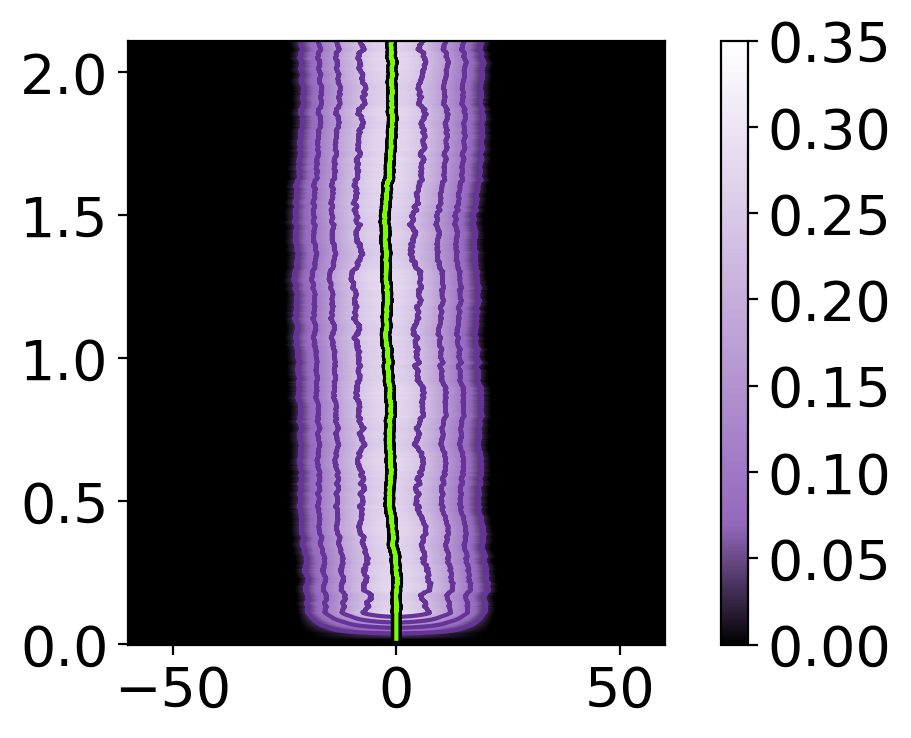

In [23]:
time_shift=int(2/0.025)
Result0=np.roll(test[:,:,3],time_shift)
Amplitudes0=np.max(test[:,:,3],axis=0)

skip=2
X, Y = np.meshgrid(x_deg[index1:index2+1], timey0[::skip], indexing='ij')

#Neural Activity
fig, (ax, cax) = plt.subplots(ncols=2,figsize=(4,4), 
                  gridspec_kw={"width_ratios":[1, 0.05]})
fig.subplots_adjust(wspace=0.2)
im  = ax.pcolormesh(X,Y,Result0[index1:index2+1,::skip],norm=divnorme,
                    cmap=cemap,shading='auto')
ax.contour(X, Y, Result0[index1:index2+1,::skip], levels=step_theta, 
           colors=5*['rebeccapurple'],linewidths=1.5)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'k',linewidth=4)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'lawngreen',linewidth=1.5)
fig.colorbar(im, cax=cax)

plt.show()

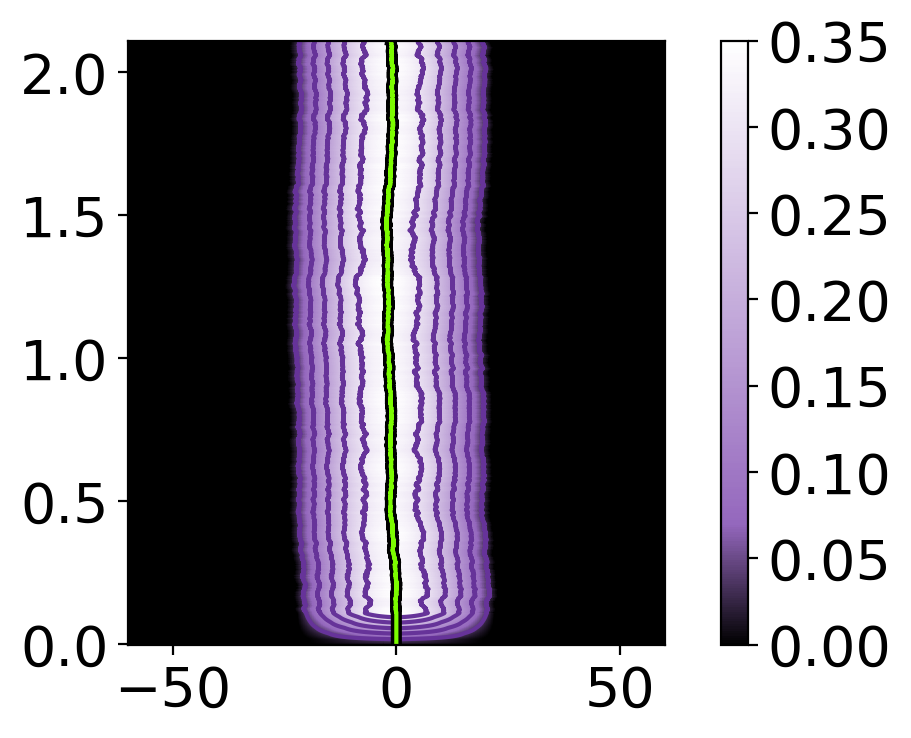

In [24]:
time_shift=int(0/0.025)
Result0=np.roll(test[:,:,4],time_shift)
Amplitudes0=np.max(test[:,:,4],axis=0)

skip=2
X, Y = np.meshgrid(x_deg[index1:index2+1], timey0[::skip], indexing='ij')

#Neural Activity
fig, (ax, cax) = plt.subplots(ncols=2,figsize=(4,4), 
                  gridspec_kw={"width_ratios":[1, 0.05]})
fig.subplots_adjust(wspace=0.2)
im  = ax.pcolormesh(X,Y,Result0[index1:index2+1,::skip],norm=divnorme,
                    cmap=cemap,shading='auto')
ax.contour(X, Y, Result0[index1:index2+1,::skip], levels=step_theta, 
           colors=5*['rebeccapurple'],linewidths=1.5)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'k',linewidth=4)
ax.plot(x_deg[np.argmax(Result0[:,time_shift:],axis=0)],timey0[time_shift:],
        'lawngreen',linewidth=1.5)
fig.colorbar(im, cax=cax)

plt.show()

# Mean Transition time
### Theory

In [25]:
#Define noise magnitude vector for theory
eps_theory=np.linspace(0.001,0.03,100)

In [26]:
#for convenience in some calculations we define the following
def U_tilde(x):
    return sum([Normal_Ucoeffs[i]*np.cos(i*x) for i in range(len(Normal_Ucoeffs))])

def U_til_prime(x):
    return sum([-Normal_Ucoeffs[i+1]*np.sin((i+1)*x)*(i+1) for i in range(len(Normal_Ucoeffs[1:]))])

def correl(z1,z2):
    return np.trapz(np.roll(noise_ker,-int(z1/dx))*np.roll(noise_ker,-int(z2/dx)),x)

In [27]:
#From a set of amplitudes and normal coefficients for five steps we obtain
#the nonlinear term G(A)
Amplitudes_sat=np.linspace(0,0.4,1000)

Utilde=U_tilde(x)

cc=np.array([np.trapz(Utilde*fun.circular_conv(weight_tot,np.roll(fun.firing(A*Utilde, step_theta),-int((len(x))/2)))*dx,x) for A in Amplitudes_sat])
factor=np.trapz(Utilde**2,x)
ga_nonlinear=np.copy(cc/factor)

#and the diffusion coefficient

xaxis=np.copy(x)
yaxis=np.copy(x)
CORR=np.copy(np.array([correl(x[0],y) for y in yaxis]))
total=0
CorrMat=[]
FullMat=[]
for i in tqdm(range(len(x))):
    CorrMat+=[np.roll(CORR,i)]
    FullMat+=[np.roll(CORR,i)*Utilde[i]*Utilde]
    total+=sum(np.roll(CORR,i)*Utilde[i]*Utilde)
DA=total*dx*dx/(factor**2)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [28]:
#found above in the stationary solution section, reprinted here
print(amp_sol)

[0.04210489 0.07126742 0.10645149 0.13871599 0.17056034 0.2062371
 0.2412802  0.26950329 0.30453165 0.33599769]


In [29]:
#defining the narrow solutions, broad solutions, and boundaries
Narrow_soln=amp_sol[0::2]
Broad_soln=np.hstack(([0],amp_sol[1::2]))
Boundaries=np.hstack(([0],Narrow_soln,[max(Amplitudes_sat)]))
print('Boundaries: ',Boundaries)
print('Stable Solutions: ',Broad_soln)

Boundaries:  [0.         0.04210489 0.10645149 0.17056034 0.2412802  0.30453165
 0.4       ]
Stable Solutions:  [0.         0.07126742 0.13871599 0.2062371  0.26950329 0.33599769]


### visualizing the probability and potential well landscape

(0.0, 0.002)

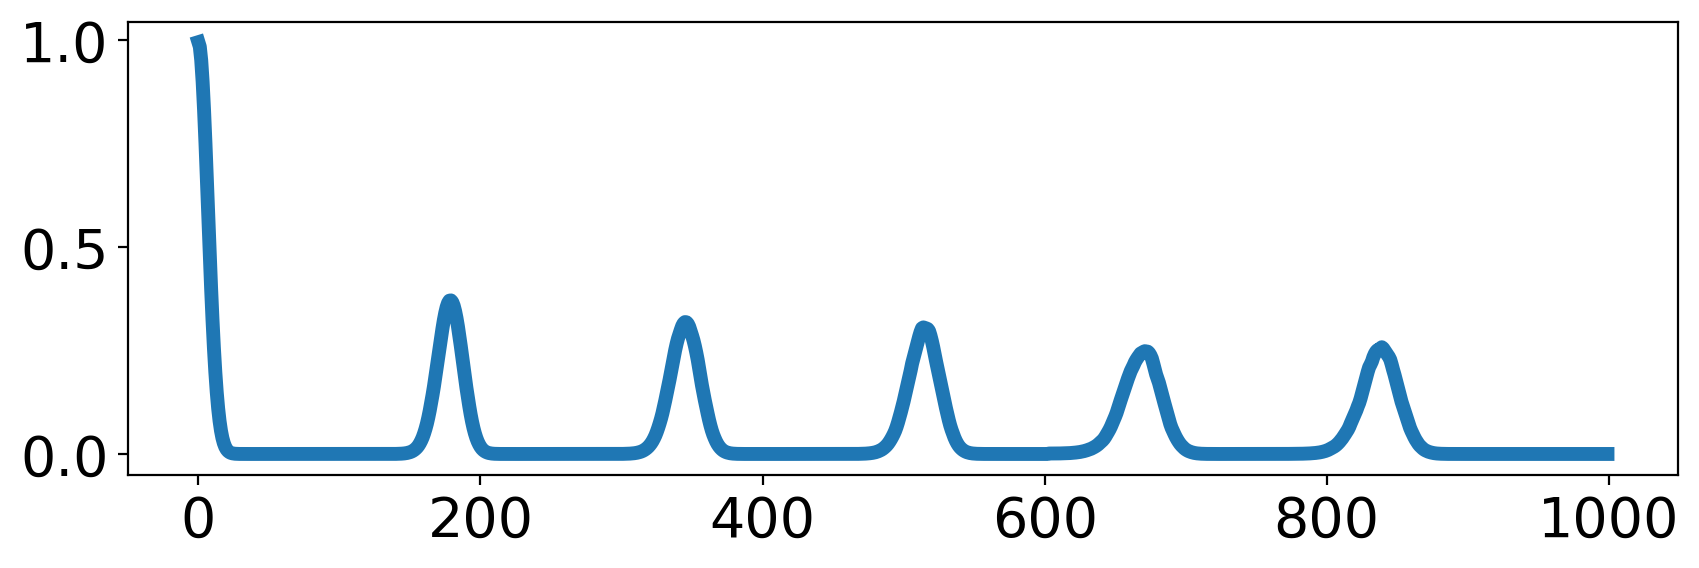

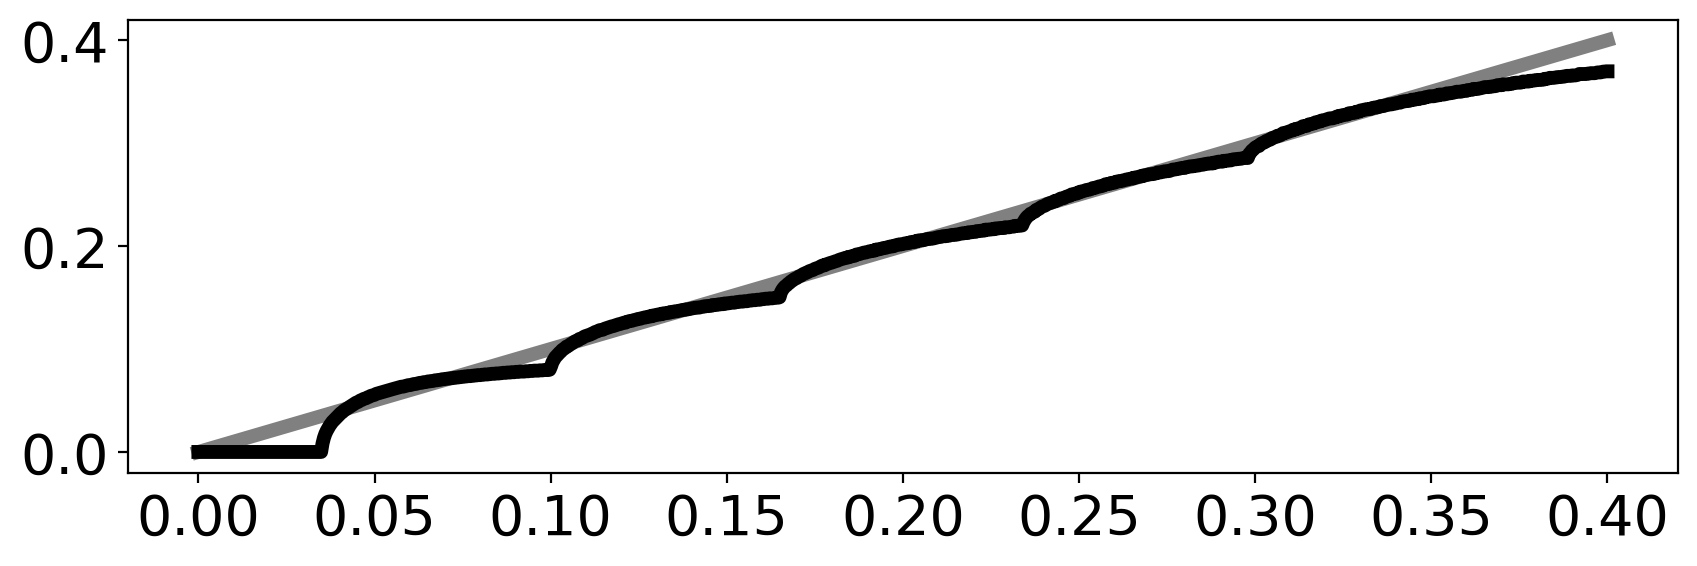

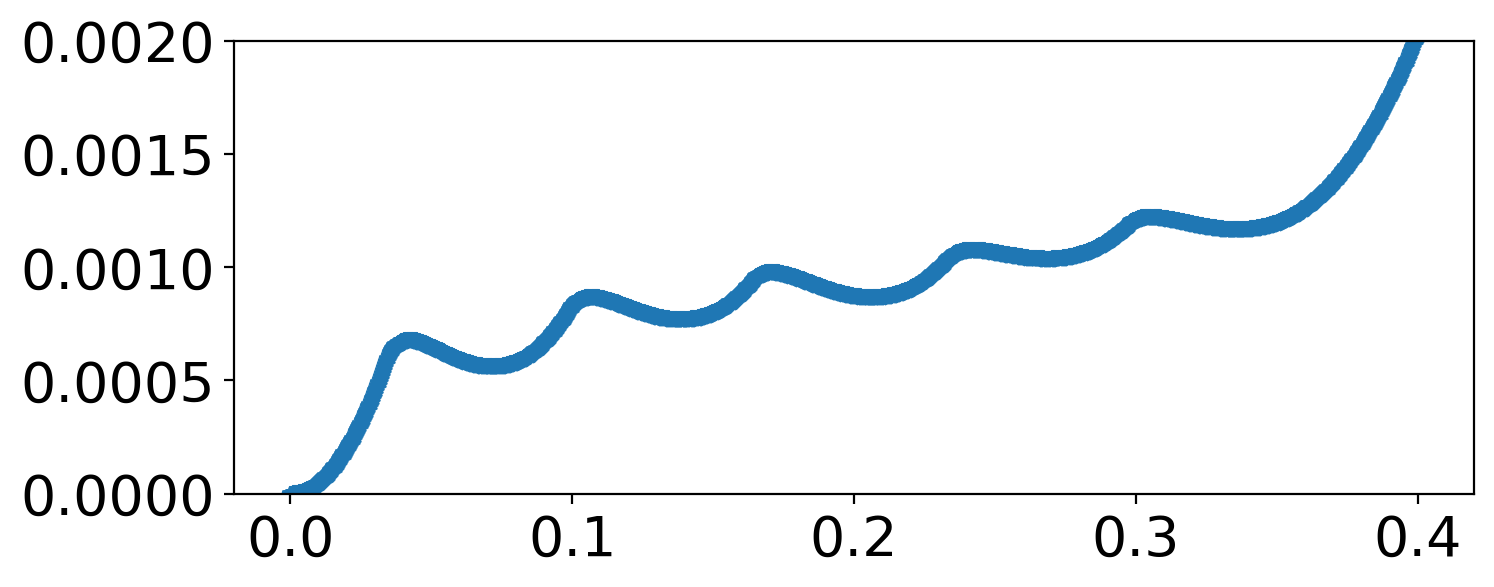

In [30]:
prob=[]

for i in range(6):
    Avec=Amplitudes_sat[(Amplitudes_sat>=Boundaries[i]) & (Amplitudes_sat<=Boundaries[i+1])]
    ga_vec=ga_nonlinear[(Amplitudes_sat>=Boundaries[i]) & (Amplitudes_sat<=Boundaries[i+1])]
    prob+=list(fun.probability_current(Broad_soln[i],0.001,noise_ker,Avec,ga_vec,Boundaries[i],x))
    
fig = plt.figure(figsize=(10, 3))
plt.plot(np.array(prob)/300)

fig = plt.figure(figsize=(10, 3))
# plt.plot(-Amplitudes_sat+ga_nonlinear, '-')
plt.plot(Amplitudes_sat,Amplitudes_sat,'grey')
plt.plot(Amplitudes_sat,ga_nonlinear,'k')

Avec=Amplitudes_sat
ga_vec=ga_nonlinear
potential=[np.trapz(Avec[Avec<=Avec[i]]-ga_vec[Avec<=Avec[i]],Avec[Avec<=Avec[i]]) for i in range(len(Avec))]

fig = plt.figure(figsize=(8, 3))
plt.plot(Amplitudes_sat,potential, '*')
plt.ylim(0,0.002)

### Sample simulation code
Below is the code to run simulations to estimate mean transition time.
This is for the lowest level state. The code must be altered accordingly to obtain transition times for other states.

In [31]:
# # Simulation used to instantiate a bump for the transition time simulation

# Tend=20
# Input=1*fun.Tophat(x, -0.02, 0.02)
# FixedParams={
#     'e': 0.001,
#     'tcs': 0,
#     'tce': 3,
#     'Tend': Tend
# }
# FixedParams['tce']=3
# Result1=fun.simulation(x,weight_tot,Input,step_theta,**FixedParams)

# numbers=10
# epsilons1=np.linspace(0.001,0.025,numbers)

# Amplitudes1=np.max(Result1,axis=0)

In [32]:
##Un-comment the following cells to obtain the data

# def transition_est1(_):
#     return fun.transitionEstimate_sim(x,weight_tot,np.copy(Result1[:,-2]),
#                                   Narrow_soln[0], Narrow_soln[1],step_theta,1000, 
#                            250,noise_ker,**FixedParams)

In [33]:
# filename="transitions_state1_sample"
# path=""

# for i in range(0,numbers):
#     FixedParams['e']=epsilons1[i]
#     print(epsilons1[i])
#     Test=Parallel(n_jobs=2)(delayed(transition_est1)(_) for _ in tqdm(range(4)))
#     with open(path+filename+".txt", 'ab') as file1:
#         np.savetxt(file1, np.array([np.hstack(Test)]), delimiter = ',')

In [34]:
#Reading in the simulation data
numbers=10
epsilons1=np.linspace(0.001,0.025,numbers)

filename="transitions_state1_sample"
path=""
file=np.loadtxt(path+filename+".txt",delimiter = ',')
meantime1=np.mean(file,axis=1)
meanstd1=np.std(file,axis=1)
med1=np.median(file,axis=1)

In [35]:
#Calculating Theory
eps_theory=np.linspace(0.001,0.03,20)
Avec=Amplitudes_sat[(Amplitudes_sat>=Boundaries[1]) & (Amplitudes_sat<=Boundaries[2])]
ga_vec=ga_nonlinear[(Amplitudes_sat>=Boundaries[1]) & (Amplitudes_sat<=Boundaries[2])]
theory_escape_time=np.array([fun.transitiontime_theory(np.copy(Amplitudes1[-1]), eps, Boundaries[1], Boundaries[2],
                                                      step_theta, DA,Avec,ga_vec,noise_ker)
                               for eps in tqdm(eps_theory)])


  0%|          | 0/20 [00:00<?, ?it/s]

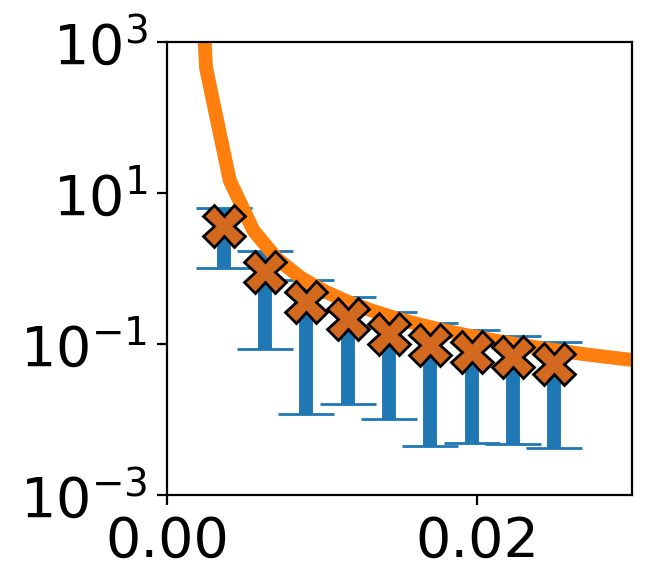

In [36]:
fig = plt.figure(figsize=(3, 3))
#Data
plt.errorbar(epsilons1, meantime1, yerr=meanstd1, 
             fmt="X",mfc='chocolate', alpha=1,mec='k',ms=15,capsize=10,label='1')
plt.plot(eps_theory, theory_escape_time)
plt.xlim(0,0.03)
plt.yscale("log") 
plt.ylim(10**(-3),10**3)
plt.show()

# Variance simulations

In [40]:
Input=1*fun.Tophat(x, -0.02, 0.02)
cue_duration=np.array([3,5,7,9,11])
Tend=200
FixedParams={
    'e': 0.001,
    'tcs': 0,
    'tce': 4,
    'Tend': Tend
}

In [41]:
####Uncomment the following to run variance simulations

# def centersSims(_):
#     return fun.centers_ampl_noise(x,weight_tot,Input,step_theta,cue_duration,noise_ker,**FixedParams)

In [42]:
# filename="cue_duration_centers_samples"
# path=""

# #Runs the simulations and writes the output in batches. 
# #For this code every batch of 200 outputs is recorded. There are 50 batches, yielding 10,000 simulations.
# for z in tqdm(range(10)):
#     Result=Parallel(n_jobs=-2)(delayed(centersSims)(_) for _ in tqdm(range(100)))
#     with open(path+filename+".txt", 'ab') as file1:
#         np.savetxt(file1, np.array(Result), delimiter = ',')

In [43]:
#Read in simulation data
filename="cue_duration_centers_samples"
path=""
file=np.loadtxt(path+filename+".txt",delimiter = ',')
centsim0=file[:,0]
centsim1=file[:,1]
centsim2=file[:,2]
centsim3=file[:,3]
centsim4=file[:,4]
print(len(centsim0[(centsim0<=np.pi/2) & (centsim0>=-np.pi/2)]))

10000


In [44]:
#VarianceTheory
def interfaces(x, U, thu, state):
    thvec=thu[:int(state)]
    pos_interface=[]
    for theta in thvec:
        interfaces_all=fun.find_interfaces(x,U,theta)
        pos_interface+=[max(interfaces_all)]
    return np.array(pos_interface)

# vector of |U Derivative| at each interface
def U_deriv(intervec,weight_coeffs,thu):
    N=len(thu)
    M=len(weight_coeffs)
    Uprim=[]
    for interface in intervec:
        Uprim+=[(2/N)*sum([weight_coeffs[i]*np.sin(i*interface)*sum([np.sin(i*infc) for infc in intervec]) 
                   for i in range(1,M)])]
    return np.array(Uprim)

def diffusion_coeff(Uprimes,inter_vec,x):
    dx=x[4]-x[3]

    def correl(z1,z2):
        return np.trapz(np.roll(noise_ker,-int(z1/dx))*np.roll(noise_ker,-int(z2/dx)),x)
    
    numerator=sum([sum([(correl(inter_vec[i],inter_vec[j])-correl(inter_vec[i],-inter_vec[j]))
                                                     for j in range(len(inter_vec))]) 
               for i in range(len(inter_vec))])
    denominator=sum([Uprimes[i] for i in range(len(inter_vec))])
    
    return 0.5*numerator/denominator**2


In [45]:
wandering_variance=[]
#Level 1 bump
inter=interfaces(x,Result1[:,-1],step_theta,1)
Uprime=U_deriv(inter,w_coeffs, step_theta)
wandering_variance+=[0.001*diffusion_coeff(Uprime,inter,x)*200*(180/np.pi)**2]

#Level 2 bump
inter=interfaces(x,Result2[:,-1],step_theta,2)
Uprime=U_deriv(inter,w_coeffs, step_theta)
wandering_variance+=[0.001*diffusion_coeff(Uprime,inter,x)*200*(180/np.pi)**2]

#Level 1 bump
inter=interfaces(x,Result3[:,-1],step_theta,3)
Uprime=U_deriv(inter,w_coeffs, step_theta)
wandering_variance+=[0.001*diffusion_coeff(Uprime,inter,x)*200*(180/np.pi)**2]

#Level 1 bump
inter=interfaces(x,Result4[:,-1],step_theta,4)
Uprime=U_deriv(inter,w_coeffs, step_theta)
wandering_variance+=[0.001*diffusion_coeff(Uprime,inter,x)*200*(180/np.pi)**2]

#Level 1 bump
inter=interfaces(x,Result5[:,-1],step_theta,5)
Uprime=U_deriv(inter,w_coeffs, step_theta)
wandering_variance+=[0.001*diffusion_coeff(Uprime,inter,x)*200*(180/np.pi)**2]

print(wandering_variance)

[30.209016342693417, 9.532991379986683, 4.532624397699061, 2.711034207780989, 1.749244483208898]


In [46]:
def plot_normal(mean, std, color='black'):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = np.exp(-0.5*(x-mean)**2/(std**2))/(std*np.sqrt(2*np.pi))
    z = plt.plot(x, p, color, linewidth=2)

Text(0.5, 1.0, 'Variance: 1.7663742523155208 degrees\nTheory: 1.749244483208898 degrees')

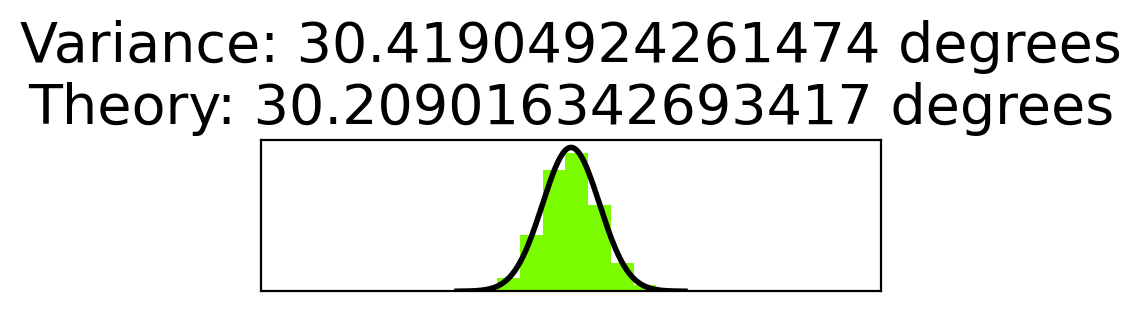

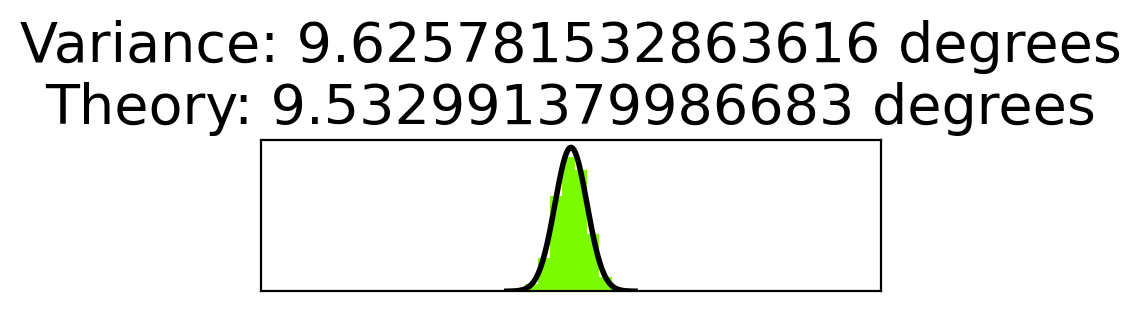

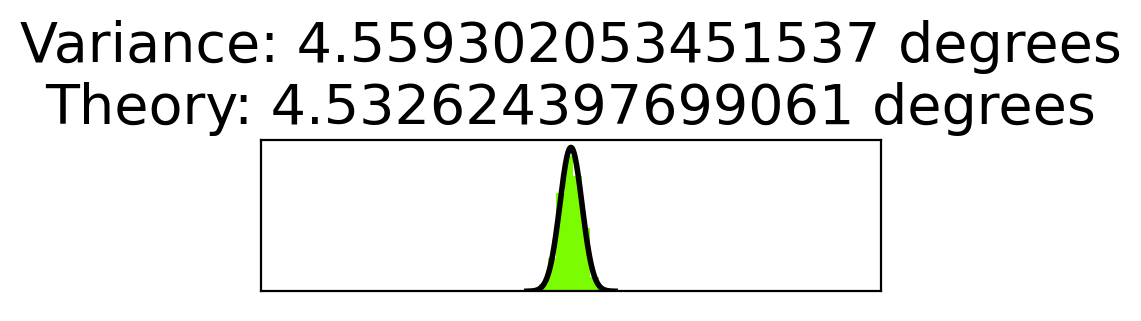

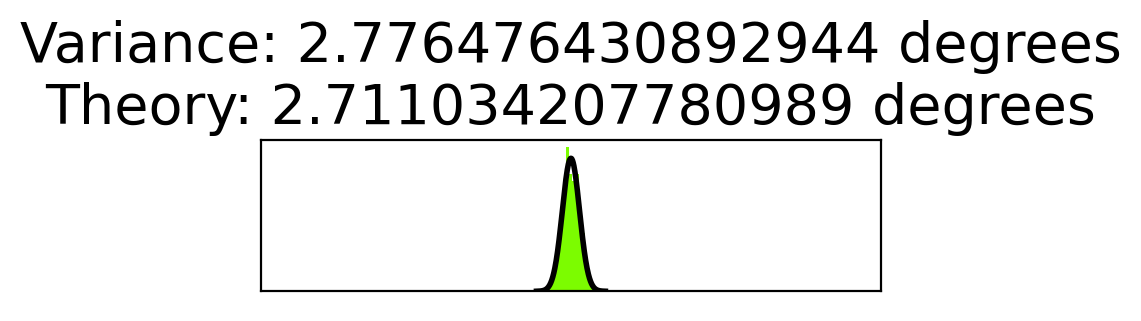

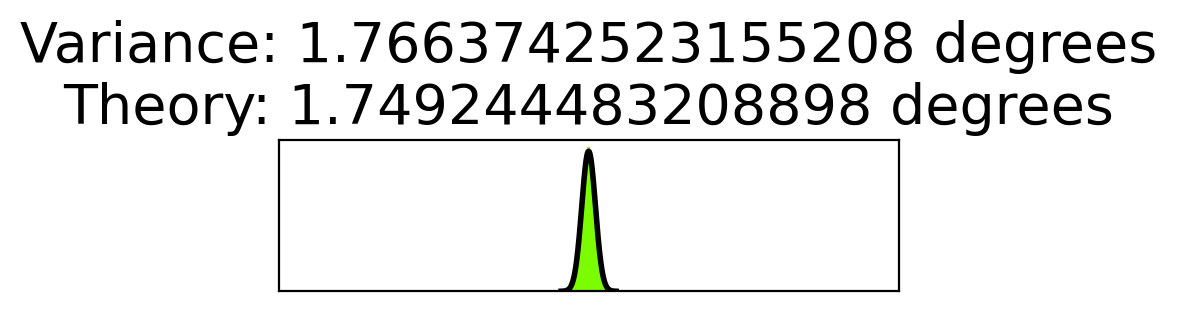

In [47]:
x_low=-60/180*np.pi
x_high=60/180*np.pi

fig = plt.figure(figsize=(4, 1))
plt.hist(centsim0,bins=10,color='lawngreen', linewidth=1.2,density=True)
plot_normal(np.mean(centsim0), np.std(centsim0))
plt.xlim(x_low,x_high)
plt.xticks([])
plt.yticks([])
plt.title('Variance: '+str(np.var(centsim0*180/np.pi))+' degrees'+'\n'
         +'Theory: '+str(wandering_variance[0])+' degrees')


fig = plt.figure(figsize=(4, 1))
plt.hist(centsim1,bins=10,color='lawngreen', linewidth=1.2,density=True)
plot_normal(np.mean(centsim1), np.std(centsim1))
plt.xlim(x_low,x_high)
plt.xticks([])
plt.yticks([])
plt.title('Variance: '+str(np.var(centsim1*180/np.pi))+' degrees'+'\n'
         +'Theory: '+str(wandering_variance[1])+' degrees')

fig = plt.figure(figsize=(4, 1))
plt.hist(centsim2,bins=10,color='lawngreen', linewidth=1.2,density=True)
plot_normal(np.mean(centsim2), np.std(centsim2))
plt.xlim(x_low,x_high)
plt.xticks([])
plt.yticks([])
plt.title('Variance: '+str(np.var(centsim2*180/np.pi))+' degrees'+'\n'
         +'Theory: '+str(wandering_variance[2])+' degrees')

fig = plt.figure(figsize=(4, 1))
plt.hist(centsim3,bins=20,color='lawngreen', linewidth=1.2,density=True)
plot_normal(np.mean(centsim3), np.std(centsim3))
plt.xlim(x_low,x_high)
plt.xticks([])
plt.yticks([])
plt.title('Variance: '+str(np.var(centsim3*180/np.pi))+' degrees'+'\n'
         +'Theory: '+str(wandering_variance[3])+' degrees')

fig = plt.figure(figsize=(4, 1))
plt.hist(centsim4,bins=20,color='lawngreen', linewidth=1.2,density=True)
plot_normal(np.mean(centsim4), np.std(centsim4))
plt.xlim(x_low,x_high)
plt.xticks([])
plt.yticks([])
plt.title('Variance: '+str(np.var(centsim4*180/np.pi))+' degrees'+'\n'
         +'Theory: '+str(wandering_variance[4])+' degrees')